# State Preparation Network
Quantum Neural Network (QNN) that compute the purity of a given state

In [4]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *

from state_preparation import state_preparation_network, layer

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
np.random.seed(42)
tf.set_random_seed(42)

## Constants

### Dataset

In [70]:
data_folder = "data/purity/one_qumode/cutoff_5/"

n_qumodes_rho = 1
n_qumodes_psi = n_qumodes_rho * 2 # for purification
n_qumodes_total = n_qumodes_psi

cutoff = 5
size_hilbert = cutoff**n_qumodes_rho

ratio_train = 0.75

### State network

In [71]:
n_layers_sp = 20

## Loading the dataset

### Loading the files

In [72]:
rhos = np.load(os.path.join(data_folder, "rhos.npy"))
list_params = np.load(os.path.join(data_folder, "list_params.npy"))
purities = np.load(os.path.join(data_folder, "purities.npy"))

In [73]:
n_samples = len(rhos)
n_samples_train = int(ratio_train*n_samples)
n_samples_test = n_samples - n_samples_train

In [74]:
# samples_idx = np.random.choice(n_samples, size=n_samples, replace=False)
# rhos = rhos[samples_idx]
# list_params = list_params[samples_idx]

### Dividing train and test

In [75]:
X_train = list_params[:n_samples_train]
X_test = list_params[n_samples_train:]
print(len(X_train))

300


## Placeholders

In [76]:
# squeeze gate
sp_sq_r = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_sq_r")
sp_sq_phi = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_sq_phi")

# displacement gate
sp_d_r = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_d_r")
sp_d_phi = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_d_phi")

# interferometer
sp_inter_theta = tf.placeholder(tf.float32, [n_layers_sp*2, int(n_qumodes_psi*(n_qumodes_psi-1)/2)], name="sp_inter_theta")
sp_inter_phi = tf.placeholder(tf.float32, [n_layers_sp*2, int(n_qumodes_psi*(n_qumodes_psi-1)/2)], name="sp_inter_phi")
sp_inter_rphi = tf.placeholder(tf.float32, [n_layers_sp*2, n_qumodes_psi-1], name="sp_inter_rphi")

# kerr gate
sp_kappa = tf.placeholder(tf.float32, [n_layers_sp, n_qumodes_psi], name="sp_kappa")

In [77]:
sp_params = [sp_sq_r, sp_sq_phi, sp_d_r, sp_d_phi, sp_inter_theta, sp_inter_phi, sp_inter_rphi, sp_kappa]

In [78]:
def get_feed_dict(params):
    return {sp_sq_r: np.array(list(params[0])),
            sp_sq_phi: np.array(list(params[1])),
            sp_d_r: np.array(list(params[2])),
            sp_d_phi: np.array(list(params[3])),
            sp_inter_theta: np.array(list(params[4])),
            sp_inter_phi: np.array(list(params[5])),
            sp_inter_rphi: np.array(list(params[6])),
            sp_kappa: np.array(list(params[7]))}

## Total Network

### Prepare the network

In [79]:
engine, q = sf.Engine(n_qumodes_total)

In [80]:
with engine:
    state_preparation_network(q, n_layers_sp, sp_params)

In [81]:
state = engine.run('tf', cutoff_dim=cutoff, eval=False, modes=0)

In [82]:
rho_output = state.dm()

In [83]:
rho_output

<tf.Tensor 'density_matrix_3:0' shape=(5, 5) dtype=complex64>

In [84]:
eps = 1e-8
purity_output = tf.real(tf.trace(rho_output @ rho_output))
eig = tf.linalg.eigvalsh(rho_output)
entropy_output = -tf.real(tf.reduce_sum(eig * tf.log(eig + eps)))
trace_output = tf.real(tf.trace(rho_output))

## Test

In [85]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [86]:
rhos.shape

(400, 5, 5)

In [87]:
list_purities_out = []
list_trace_out = []
for i_sample in range(n_samples):
    feed_dict = get_feed_dict(list_params[i_sample])
    list_purities_out.append(sess.run(purity_output, feed_dict=feed_dict))
    list_trace_out.append(sess.run(trace_output, feed_dict=feed_dict))
    clear_output(wait=True)
    print(i_sample)
list_purities_out = np.array(list_purities_out)
list_trace_out = np.array(list_trace_out)

399


In [88]:
# list_entropies_out = []
# for i_sample in range(n_samples):
#     feed_dict = get_feed_dict(list_params[i_sample])
#     list_entropies_out.append(sess.run(entropy_output, feed_dict=feed_dict))
#     clear_output(wait=True)
#     print(i_sample)

(array([40., 40., 40., 40., 40., 39., 40., 41., 38., 42.]),
 array([0.20166264, 0.28108737, 0.3605121 , 0.43993682, 0.51936156,
        0.5987863 , 0.67821103, 0.7576358 , 0.83706045, 0.9164852 ,
        0.9959099 ], dtype=float32),
 <a list of 10 Patch objects>)

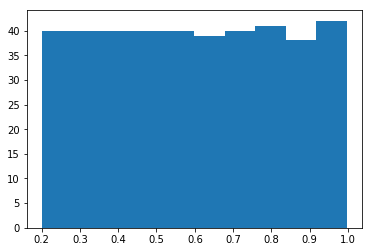

In [89]:
plt.hist(list_purities_out)

(array([ 2.,  5., 17., 19., 31., 71., 86., 90., 53., 26.]),
 array([0.925616  , 0.93285763, 0.9400993 , 0.9473409 , 0.9545826 ,
        0.9618242 , 0.9690658 , 0.97630745, 0.98354906, 0.9907907 ,
        0.99803233], dtype=float32),
 <a list of 10 Patch objects>)

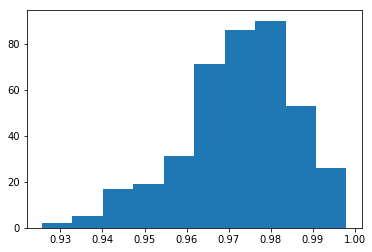

In [90]:
plt.hist(list_trace_out)

(array([40., 41., 39., 40., 40., 40., 39., 41., 38., 42.]),
 array([0.20310573, 0.28250514, 0.36190454, 0.44130395, 0.52070335,
        0.60010276, 0.67950216, 0.75890157, 0.83830097, 0.91770038,
        0.99709978]),
 <a list of 10 Patch objects>)

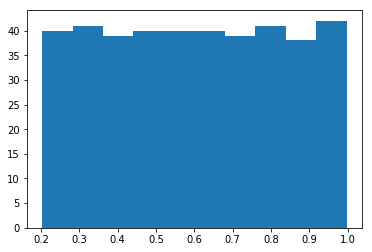

In [91]:
plt.hist(purities)

(array([395.,   2.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([1.18242346e-11, 6.49946797e-05, 1.29989348e-04, 1.94984016e-04,
        2.59978683e-04, 3.24973351e-04, 3.89968019e-04, 4.54962687e-04,
        5.19957355e-04, 5.84952023e-04, 6.49946691e-04]),
 <a list of 10 Patch objects>)

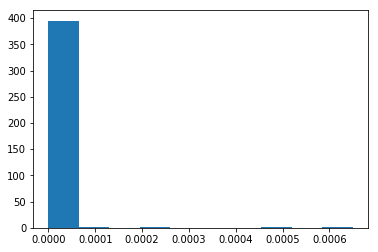

In [95]:
plt.hist(np.square(purities - list_purities_out))

In [41]:
# np.save(os.path.join(data_folder, "entropies.npy"), list_entropies_out)